# Analysis of STAR Solo Counts at Gene and GeneFull Levels

**Author**

```
Tzintzuni I. Garcia PhD
Senior Bioinformatician
Center for Translational Data Science
The University of Chicago
```
https://github.com/tzuni


**Background**

[Star Solo](https://github.com/alexdobin/STAR) aligns and quantifies single cell RNA seq data in a convenient single command. It works with 10x and SmartSeq style data and can produce counts for various levels including but not limited to `Gene` and `GeneFull`.

- `Gene` is what you would expect for typical gene expression
- `GeneFull` also counts reads aligned to introns; this is designed to evaluate unprocessed transcript levels

**The 'Huh' Moment**

In evaluating this tool I noticed something strange; the counts I got for `Gene` were overall higher than those for `GeneFull`. The counts per gene tended to be higher in `Gene` vs `GeneFull` and many features that had counts in `Gene` had 0 in `GeneFull`. I contacted Alex Dobin and he suggested that overlapping gene features could be the culprit. Specifically if a gene annotation existed in the intron of another gene, it would be a clear call when counting reads for each in the `Gene` mode, but those reads would become ambiguous in the `GeneFull` mode.

**Analysis**

At the time of this analysis the SmartSeq mode of StarSolo is supported only by the [develop branch of STAR](https://github.com/alexdobin/STAR/tree/develop). I obtained a set of single cell RNA smart seq data from SRA [PRJNA437328](https://www.ncbi.nlm.nih.gov/bioproject/PRJNA437328). I generated a new STAR index using the hg38 reference sequences enhanced with viral decoy sequences and the gencode v22 [provided by the GDC](https://gdc.cancer.gov/about-data/data-harmonization-and-generation/gdc-reference-files). Gene biotypes were extracted from the GTF file and overlapping gene features were found using [pyranges](https://github.com/biocore-ntnu/pyranges). With this information collected, I produced a series of scatterplots to examine the behavior of different gene biotypes quantified by `Gene` vs `GeneFull`.

**Results**

These results support Alex's hypothesis that overlapping features can cause reads which were clearly assigned in the `Gene` mode to become ambiguous in the `GeneFull` mode. Genes that fully overlapped another gene had no counts in the `GeneFull` mode, and the fraction of coverage seems to be a major factor in reduced counts. Anyone using the `GeneFull` quantification mode should take this into consideration as it is designed to address the .

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

## Load Data

**Gene**

In [2]:
gene_mtx_file = '../Gene/raw/matrix.mtx'
gene_features_file = '../Gene/raw/features.tsv'

In [3]:
# load sparse matrix data
names=['feature', 'cell', 'umi_collapse', 'no_dedup']
gmtx = pd.read_table(gene_mtx_file, sep=' ', header=None, skiprows=3, names=names)

# load features
names = ['ENSG', 'symbol']
gfeatures = pd.read_table(gene_features_file, header=None, names=names)
# starSolo seems to be 1-based index
gfeatures.index = gfeatures.index + 1

**GeneFull**

In [4]:
genefull_mtx_file = '../GeneFull/raw/matrix.mtx'

In [5]:
# load sparse matrix data
names=['feature', 'cell', 'umi_collapse', 'no_dedup']
gfmtx = pd.read_table(genefull_mtx_file, sep=' ', header=None, skiprows=3, names=names)

**Combine for plotting**

In [6]:
gmtx = gmtx.set_index(['feature', 'cell'])
gfmtx = gfmtx.set_index(['feature', 'cell'])

In [7]:
common_set = pd.merge(gmtx['umi_collapse'], gfmtx['umi_collapse'], left_index=True, right_index=True, how='outer')
common_set.columns = ['Gene', 'GeneFull']
common_set = common_set.fillna(0)

In [8]:
common_set.head()

Gene  GeneFull
feature cell                
2       3      0.0       4.0
        6      3.0       2.0
        7      1.0       1.0
        8      0.0       5.0
        9      0.0       9.0

**Add gene biotype and overlap data**

Gene biotypes were extracted from the GTF

Gene overlap data was separately determined using pyranges library with ranges from the GTF

In [9]:
gtdf = pd.read_table('gene_types.tsv')

# merge gene types with features
fdf = pd.merge(gfeatures.reset_index(), gtdf, left_on='ENSG', right_on='gene_id')
fdf = fdf.drop(columns=['gene_id'])
fdf = fdf.rename(columns={'index': 'key'})

# map index to gene_type
gt_map = pd.Series(fdf.gene_type.values, index=fdf.key).to_dict()
oc_map = pd.Series(fdf.overlap_counts.values, index=fdf.key).to_dict()
oo_map = pd.Series(fdf.overlap_other.values, index=fdf.key).to_dict()
of_map = pd.Series(fdf.overlap_fraction.values, index=fdf.key).to_dict()
common_set['gene_type'] = common_set.index.get_level_values('feature').map(gt_map)
common_set['overlap_counts'] = common_set.index.get_level_values('feature').map(oc_map)
common_set['overlap_other'] = common_set.index.get_level_values('feature').map(oo_map)
common_set['overlap_fraction'] = common_set.index.get_level_values('feature').map(of_map)

In [10]:
# Group into broader classes
classes = {
    'protein_coding': 'protein_coding',
    'IG_C_gene': 'protein_coding',
    'TR_C_gene': 'protein_coding',
    'TR_V_gene': 'protein_coding',
    'unprocessed_pseudogene': 'pseudogene',
    'processed_pseudogene': 'pseudogene',
    'unitary_pseudogene': 'pseudogene',
    'transcribed_processed_pseudogene': 'pseudogene',
    'transcribed_unprocessed_pseudogene': 'pseudogene',
    'polymorphic_pseudogene': 'pseudogene',
    'pseudogene': 'pseudogene',
    'lincRNA': 'lncRNA',
    'antisense': 'lncRNA',
    'sense_overlapping': 'lncRNA',
    'sense_intronic': 'lncRNA',
    'processed_transcript': 'lncRNA',
    '3prime_overlapping_ncrna': 'lncRNA',
    'macro_lncRNA': 'lncRNA',
    'Mt_rRNA': 'noncoding RNA',
    'Mt_tRNA': 'noncoding RNA',
    'misc_RNA': 'noncoding RNA',
    'miRNA': 'noncoding RNA',
    'snRNA': 'noncoding RNA',
    'snoRNA': 'noncoding RNA',
    'sRNA': 'noncoding RNA',
    'rRNA': 'noncoding RNA',
    'TEC': 'To be Experimentally Confirmed',
}

common_set['broad_gene_type'] = common_set['gene_type'].map(classes)

In [11]:
def abline(slope, intercept, ax=None):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    if ax is None:
        plt.plot(x_vals, y_vals, '--', color='gray')
    else:
        ax.plot(x_vals, y_vals, '--', color='gray')

## Explore Data with Plots

In [12]:
common_set.head()

Gene  GeneFull               gene_type  overlap_counts  \
feature cell                                                           
2       3      0.0       4.0  unprocessed_pseudogene               3   
        6      3.0       2.0  unprocessed_pseudogene               3   
        7      1.0       1.0  unprocessed_pseudogene               3   
        8      0.0       5.0  unprocessed_pseudogene               3   
        9      0.0       9.0  unprocessed_pseudogene               3   

             overlap_other  overlap_fraction broad_gene_type  
feature cell                                                  
2       3             True          0.005802      pseudogene  
        6             True          0.005802      pseudogene  
        7             True          0.005802      pseudogene  
        8             True          0.005802      pseudogene  
        9             True          0.005802      pseudogene

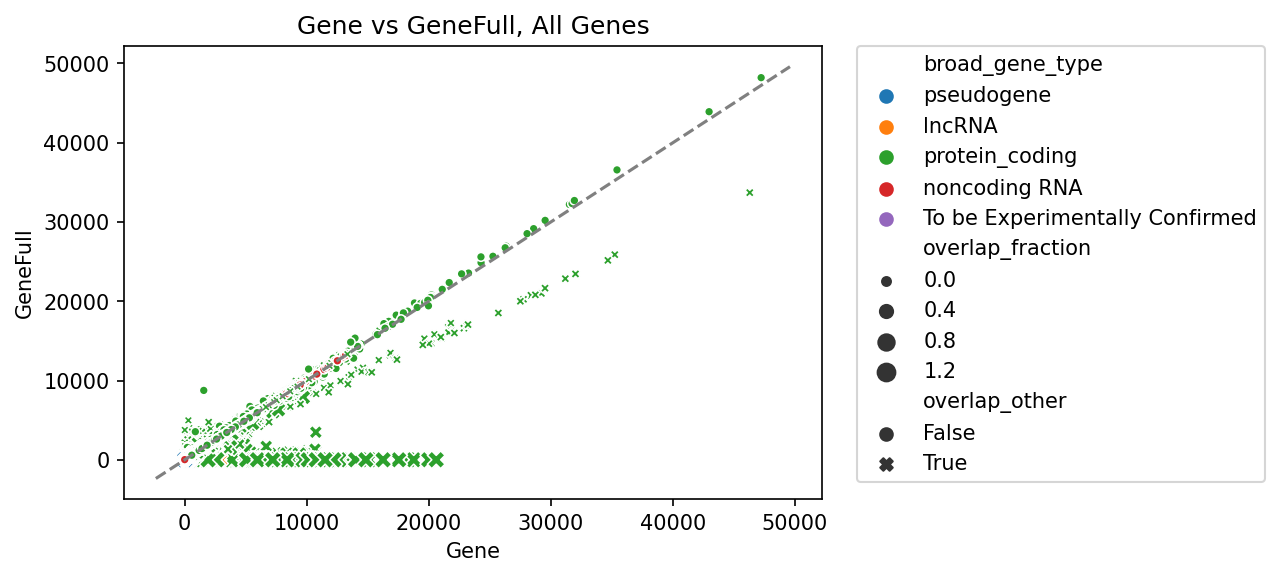

In [13]:
fig, ax = plt.subplots(1,1)
sns.scatterplot(data=common_set, x='Gene', y='GeneFull', hue='broad_gene_type',
                style='overlap_other', size='overlap_fraction', ax=ax)
abline(1,0, ax)
ax.set_title("Gene vs GeneFull, All Genes")
plt.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0.)


Overall it looks obvious that gene features that overlap another feature have higher counts in `Gene` leading to a lot of off-diagonal points. Concordantly genes that completely overlap another gene have no measured expression in `GeneFull`. The protein coding genes dominate this plot so the subsequent plots break down gene features by biotype.

## protein coding genes

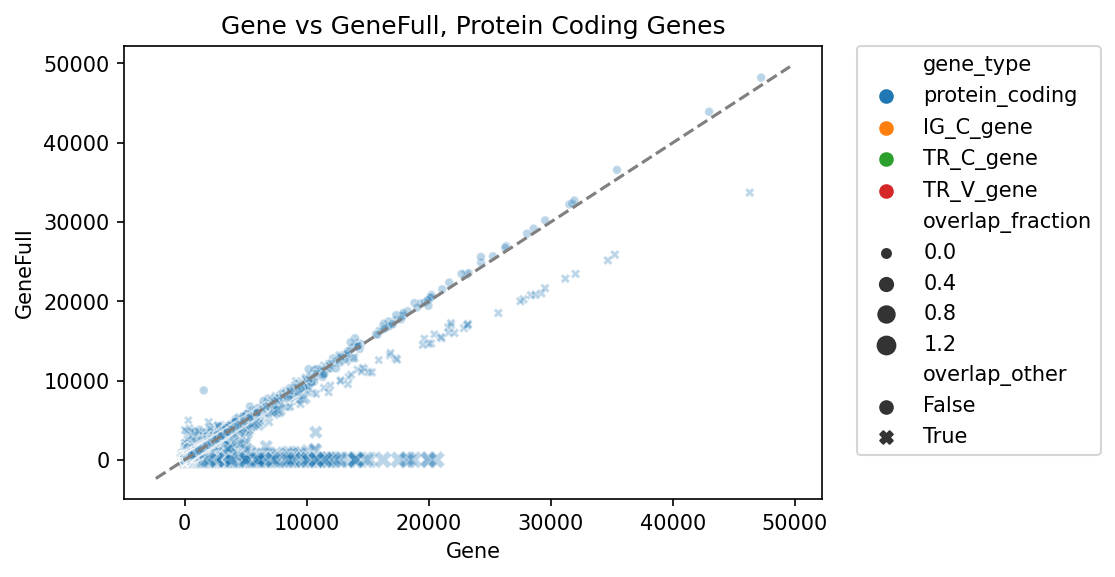

In [14]:
sel = common_set['broad_gene_type'] == 'protein_coding'
fig, ax = plt.subplots(1,1)
sns.scatterplot(data=common_set.loc[sel], x='Gene', y='GeneFull', hue='gene_type',
                style='overlap_other', size='overlap_fraction', alpha=0.3, ax=ax)
abline(1,0, ax)
ax.set_title("Gene vs GeneFull, Protein Coding Genes")
plt.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0.)

Even with transparency it's hard to see where the specific immune-related biotype gene features lie. The vast majority of off-diagonal features are below the line and marked as overlapping. It seems clear that in the case of protein-coding genes, overlapping features are the main cause of reduced counts in `GeneFull` vs `Gene`.

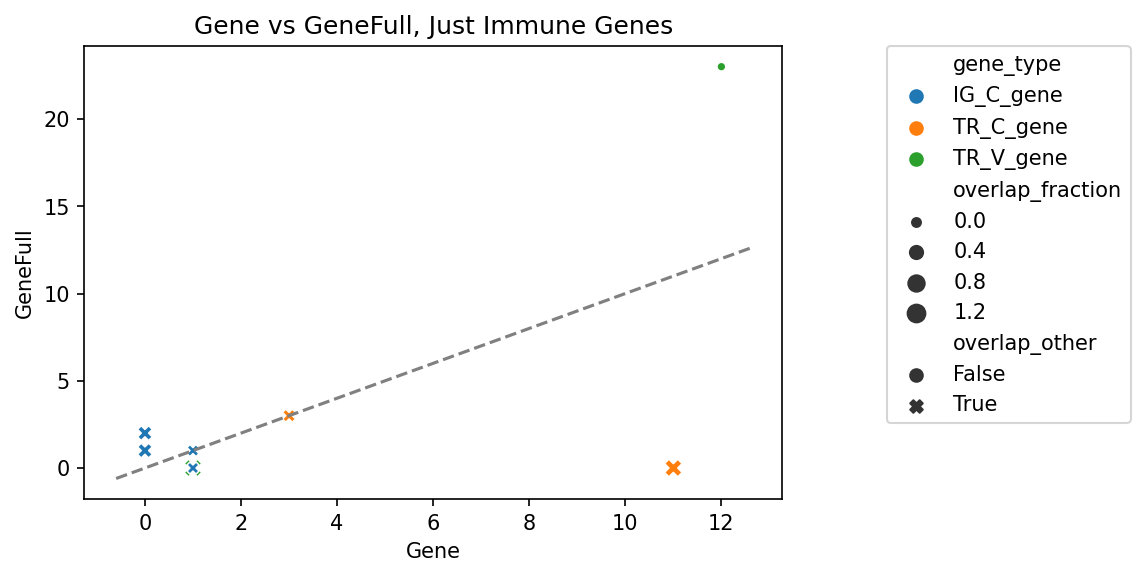

In [15]:
sel = common_set['gene_type'].isin(['TR_V_gene', 'IG_C_gene', 'TR_C_gene'])
fig, ax = plt.subplots(1,1)
sns.scatterplot(data=common_set.loc[sel], x='Gene', y='GeneFull', hue='gene_type',
                style='overlap_other', size='overlap_fraction', alpha=1, ax=ax)
abline(1,0, ax)
ax.set_title("Gene vs GeneFull, Just Immune Genes")
plt.legend(bbox_to_anchor=(1.15, 1), borderaxespad=0.)

It turns out there are only a handful of these in the results.

## pseudogenes

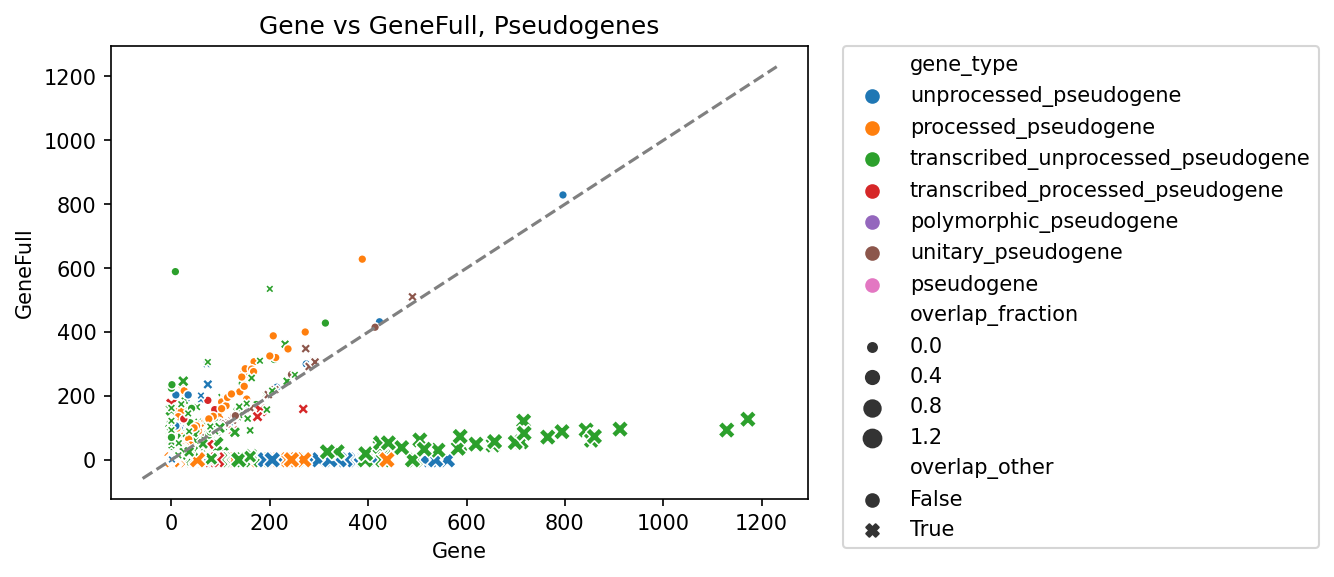

In [16]:
sel = common_set['broad_gene_type'] == 'pseudogene'
fig, ax = plt.subplots(1,1)
sns.scatterplot(data=common_set.loc[sel], x='Gene', y='GeneFull', hue='gene_type',
                style='overlap_other', size='overlap_fraction', alpha=1, ax=ax)
abline(1,0, ax)
ax.set_title("Gene vs GeneFull, Pseudogenes")
plt.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0.)

## lncRNA

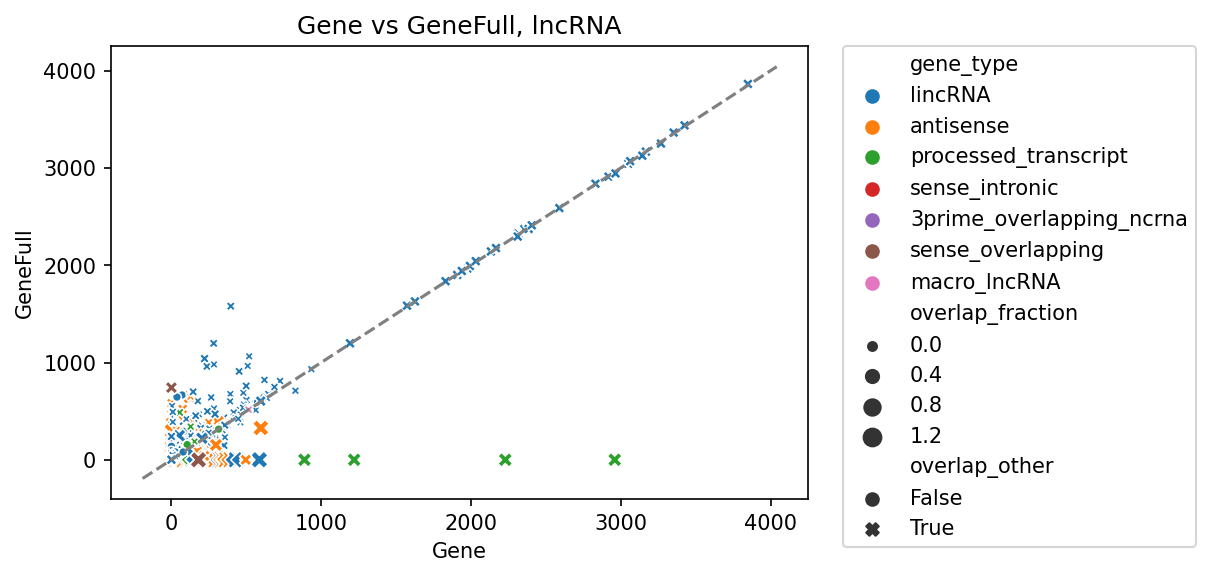

In [17]:
sel = common_set['broad_gene_type'] == 'lncRNA'
fig, ax = plt.subplots(1,1)
sns.scatterplot(data=common_set.loc[sel], x='Gene', y='GeneFull', hue='gene_type', style='overlap_other', size='overlap_fraction', ax=ax)
abline(1,0, ax)
ax.set_title("Gene vs GeneFull, lncRNA")
plt.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0.)

## Noncoding RNA

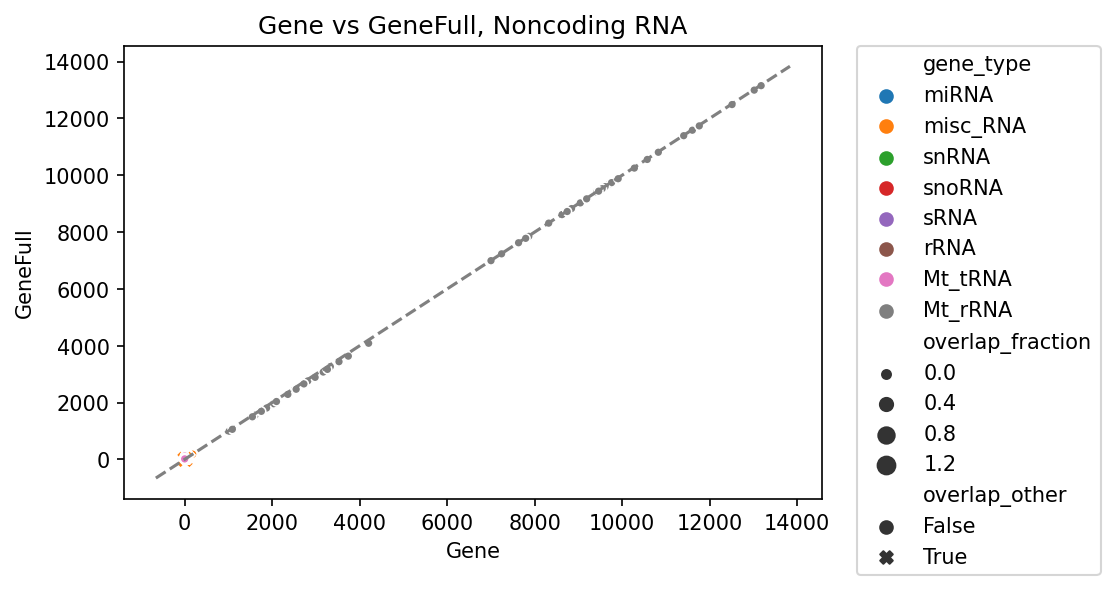

In [18]:
sel = common_set['broad_gene_type'] == 'noncoding RNA'
fig, ax = plt.subplots(1,1)
sns.scatterplot(data=common_set.loc[sel], x='Gene', y='GeneFull', hue='gene_type', style='overlap_other', size='overlap_fraction', ax=ax)
abline(1,0, ax)
ax.set_title("Gene vs GeneFull, Noncoding RNA")
plt.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0.)

There hardly seem to be any overlapping features in the remaining noncoding RNA types, and all these features seem to fall solidly on the diagonal.

## To be Experimentally Confirmed

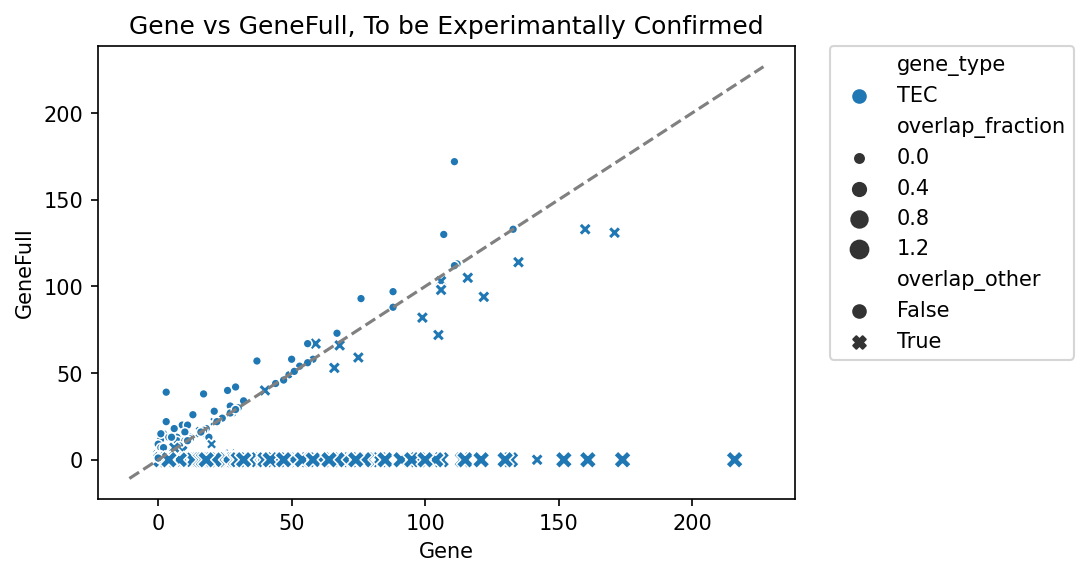

In [19]:
sel = common_set['broad_gene_type'] == 'To be Experimentally Confirmed'
fig, ax = plt.subplots(1,1)
sns.scatterplot(data=common_set.loc[sel], x='Gene', y='GeneFull', hue='gene_type', style='overlap_other', size='overlap_fraction', ax=ax)
abline(1,0, ax)
ax.set_title("Gene vs GeneFull, To be Experimantally Confirmed")
plt.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0.)

This final category is for features that need validation, again mostly the under-expressed features are those that overlap others.